Lets start by dividing the task into some components that are necessary to implement:

1. Data Preprocessing
2. Text-Based Product Recommendation
3. Image-Based Product Recommendation
4. Integration - Combine recommendation systems and get a list of final recommendations
5. Evaluation - Fine tunning the **parameters**

# **Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import itertools
import nltk
from nltk.corpus import stopwords
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import pickle
import warnings
#warnings.filterwarnings("ignore")

# Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Load the dataset
import pandas as pd
file_path =file_path = '/content/drive/My Drive/DataMining Project/28k_apparel_data.csv'
dataset = pd.read_csv(file_path)

print("Number of data points in dataset: ", dataset.shape[0], \
      "Number of variables: ", dataset.shape[1])


Mounted at /content/drive
Number of data points in dataset:  17593 Number of variables:  8


We'll start by analyzing the dataset to identify duplicates and handle missing data for various features. We'll examine each variable to determine the number of missing values for each feature.

To accomplish this, we'll utilize the describe() function to obtain the count for each exact feature. If the count doesn't match the total number of clothes (17,593), it indicates missing values in that feature.

In [ ]:
print(dataset["product_type_name"].describe())
# From the print we can see that there are no missing values in product_type_name.

count     17593
unique       55
top       SHIRT
freq      13980
Name: product_type_name, dtype: object


In [ ]:
print(dataset["brand"].describe())

# From the print we can see that there are 17543 brands in total, meaning that
# we have 17593 - 17543 = 50 missing values

count         17543
unique         3559
top       Anna-Kaci
freq            117
Name: brand, dtype: object


In [ ]:
print(dataset["color"].describe())

# From the print we can see that there are no missing values in color.

count     17593
unique     3868
top       Black
freq       3127
Name: color, dtype: object


In [ ]:
print(dataset["medium_image_url"].describe())

# As we can see every item has its own image, but only 16398 are unique, meaning
# that we have 17593 - 16398 = 1195 duplicate images.


count                                                 17593
unique                                                16398
top       https://images-na.ssl-images-amazon.com/images...
freq                                                     11
Name: medium_image_url, dtype: object


In [ ]:
print(dataset["asin"].describe())

# Every item as a unique asin which is great.

count          17593
unique         17593
top       B004GSI2OS
freq               1
Name: asin, dtype: object


In [ ]:
print(dataset["formatted_price"].describe())

# From the print we can see that there are no missing values in formatted_price


count      17593
unique      2860
top       $19.99
freq         514
Name: formatted_price, dtype: object


In [ ]:
print(dataset['title'].describe())
# From the print we can see that there are no missing values in title, but we
# can still have duplicates where 3 or more words are the same.

count                                                 17593
unique                                                17593
top       Featherlite Ladies' Long Sleeve Stain Resistan...
freq                                                      1
Name: title, dtype: object


After identifying features with missing values, our next step is to remove the rows containing these missing values and compare the resulting dataset with the original one.

In [ ]:
data = dataset.loc[~dataset['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

data = dataset.loc[~dataset['asin'].isnull()]
print('Number of data points After eliminating asin=NULL :', data.shape[0])

data = dataset.loc[~dataset['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

data = dataset.loc[~dataset['title'].isnull()]
print('Number of data points After eliminating title=NULL :', data.shape[0])

data = dataset.loc[~dataset['medium_image_url'].isnull()]
print('Number of data points After eliminating medium_image_url=NULL :', data.shape[0])

data = dataset.loc[~dataset['brand'].isnull()]
print('Number of data points After eliminating brand=NULL :', data.shape[0])

# Verified that only brand has missing values which were removed.
# We can see that we have brought down the number of data points from 17593 to
# 17543 by removing missing values.

Number of data points After eliminating price=NULL : 17593
Number of data points After eliminating asin=NULL : 17593
Number of data points After eliminating color=NULL : 17593
Number of data points After eliminating title=NULL : 17593
Number of data points After eliminating medium_image_url=NULL : 17593
Number of data points After eliminating brand=NULL : 17543


# Saving the modified dataset on our Google Drive


In [ ]:
num_rows = data.shape[0]

num_rows
data.to_csv("/content/drive/My Drive/DataMining Project/modified_dataset.csv", index=True)



In [ ]:

modified_csv_file_path = "/content/drive/My Drive/DataMining Project/modified_dataset.csv"

data = pd.read_csv(modified_csv_file_path)

num_rows = data.shape[0]

num_rows

17543

# Removing all products with less than 5 wods in title

In [ ]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])
print('Number of data points After eliminating brand=NULL :', data.shape[0])


After removal of products with short description: 17543
Number of data points After eliminating brand=NULL : 17543


# Remove duplicates : Part 1


In [ ]:
# Sort the whole data based on title (alphabetical order of title)
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()
print('Number of data points After eliminating brand=NULL :', data.shape[0])


Number of data points After eliminating brand=NULL : 17543


In [ ]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [ ]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:

    previous_i = i

    a = dataset['title'].loc[indices[i]].split()

    j = i+1
    while j < num_data_points:

        b = dataset['title'].loc[indices[j]].split()

        length = max(len(a), len(b))

        count  = 0
        for k in itertools.zip_longest(a,b):
            if (k[0] == k[1]):
                count += 1

        if (length - count) > 2: 
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]


In [ ]:
print('Number of data points : ', data.shape[0])


Number of data points :  17543


In [ ]:
data.to_csv("/content/drive/My Drive/DataMining Project/modified_dataset.csv", index=True)


In [ ]:
modified_csv_file_path = "/content/drive/My Drive/DataMining Project/modified_dataset.csv"

data = pd.read_csv(modified_csv_file_path)

# Removing Duplicate Words - Title with 3 or more duplicates words

In [ ]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    a = data['title'].loc[i].split()
    for j in indices:

        b = data['title'].loc[j].split()

        length = max(len(a),len(b))

        count  = 0
        for k in itertools.zip_longest(a,b):
            if (k[0]==k[1]):
                count += 1

        if (length - count) < 3:
            indices.remove(j)

In [ ]:
# from whole previous products we will consider only
# the products that are found in previous cell
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

# Result after removing missing values and cleaning up the duplicates

In [ ]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16389


# Saving the modified dataset to Google Drive folder

In [ ]:
data.to_csv("/content/drive/My Drive/DataMining Project/modified_dataset.csv", index=True)


In [ ]:
modified_csv_file_path = "/content/drive/My Drive/DataMining Project/modified_dataset.csv"

data = pd.read_csv(modified_csv_file_path)

In [ ]:
data

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        asin  \
0                 0             0             0           4  B004GSI2OS   
1                 1             1             1           6  B012YX2ZPI   
2                 2             2             2          15  B003BSRPB0   
3                 3             3             3          27  B014ICEJ1Q   
4                 5             5             5          46  B01NACPBG2   
...             ...           ...           ...         ...         ...   
16384         17538         17538         17588      183081  B01MRV2IFS   
16385         17539         17539         17589      183092  B01LY4QWLF   
16386         17540         17540         17590      183096  B07167SCNH   
16387         17541         17541         17591      183101  B07575N2WX   
16388         17542         17542         17592      183120  B01NCO06S0   

                             brand              color  \
0                      FeatherLite  Onyx Black/ Stone   
1      HX-Kingdom Fashion T-shirts              White   
2                      FeatherLite              White   
3                            FNC7C             Purple   
4                     Fifth Degree              Black   
...                            ...                ...   
16384                      YueLian              Black   
16385              Vintage America              White   
16386             Tart Collections              Black   
16387                      Soprano               Gray   
16388                  Faded Glory          Blue/Grey   

                                        medium_image_url product_type_name  \
0      https://images-na.ssl-images-amazon.com/images...             SHIRT   
1      https://images-na.ssl-images-amazon.com/images...             SHIRT   
2      https://images-na.ssl-images-amazon.com/images...             SHIRT   
3      https://images-na.ssl-images-amazon.com/images...             SHIRT   
4      https://images-na.ssl-images-amazon.com/images...             SHIRT   
...                                                  ...               ...   
16384  https://images-na.ssl-images-amazon.com/images...             SHIRT   
16385  https://images-na.ssl-images-amazon.com/images...             SHIRT   
16386  https://images-na.ssl-images-amazon.com/images...             SHIRT   
16387  https://images-na.ssl-images-amazon.com/images...             SHIRT   
16388  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                   title formatted_price  
0      Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
1      Women's Unique 100% Cotton T - Special Olympic...           $9.99  
2      FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
3      Supernatural Chibis Sam Dean And Castiel O Nec...           $7.39  
4      Fifth Degree Womens Gold Foil Graphic Tees Jun...           $6.95  
...                                                  ...             ...  
16384  YueLian Women's Chiffon Short Sleeves Sun Prot...          $19.25  
16385  Vintage America Women's Large Lace Up Collared...          $23.24  
16386    Tart Womens Collections Ann Wrap Top, Xs, Black          $29.99  
16387  Soprano Womens Small Tie-Fringe Slub-Knit Tank...          $22.83  
16388  Faded Glory Women's Plaid Button Down 2 Pocket...          $18.99  

[16389 rows x 11 columns]

In [ ]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16389


# Downloading Images and saving them on our Google Drive


In [ ]:
from google.colab import drive
import os
import requests

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory in Google Drive where you want to save images
image_directory = '/content/drive/My Drive/DataMining Project/images/'
os.makedirs(image_directory, exist_ok=True)

def download_and_save_image(url, filename):
    if os.path.exists(filename):
        print(f"Image already exists: {filename}. Skipping download.")
        return
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                f.write(response.content)
                print(f"Image saved: {filename}")
        else:
            print(f"Failed to download image from {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading image from {url}: {e}")

# Iterate over the dataset and download images
for index, row in data.iterrows():
    image_url = row['medium_image_url']
    image_name = f"{row['asin']}.jpg"
    image_path = os.path.join(image_directory, image_name)
    download_and_save_image(image_url, image_path)


Srautinio perdavimo išvestis sutrumpinta iki kelių paskutinių eilučių (5000).
Image saved: /content/drive/My Drive/DataMining Project/images/B0141ZT1EK.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B01M0FB70X.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B01KDCI5RE.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B074WF471Z.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B0723B6NSJ.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B071VW5BH2.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B01M4MWVNV.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B01F2VWD60.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B07481GQLF.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B071WH8X5R.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B06XRD7Q4X.jpg
Image saved: /content/drive/My Drive/DataMining Project/images/B

In [ ]:
pd.DataFrame(data['product_type_name'].value_counts())


count
product_type_name                      
SHIRT                             13133
BOOKS_1973_AND_LATER               1360
APPAREL                             634
ACCESSORY                           315
SPORTING_GOODS                      197
DRESS                               144
BLAZER                               95
SWEATER                              80
OUTERWEAR                            74
OUTDOOR_RECREATION_PRODUCT           64
UNDERWEAR                            35
SLEEPWEAR                            35
PANTS                                22
SKIRT                                20
TOYS_AND_GAMES                       20
MISC_OTHER                           19
AUTO_ACCESSORY                       18
ETHNIC_WEAR                          16
POWERSPORTS_PROTECTIVE_GEAR           9
HANDBAG                               9
HEALTH_PERSONAL_CARE                  8
BRA                                   8
SHOES                                 7
HAT                                   6
BEAUTY                                6
ADULT_COSTUME                         6
HOME                                  6
OFFICE_PRODUCTS                       4
TOOLS                                 4
OUTDOOR_LIVING                        3
SAFETY_SUPPLY                         2
SUIT                                  2
SOUND_AND_RECORDING_EQUIPMENT         2
POWERSPORTS_VEHICLE_PART              2
BABY_COSTUME                          2
MECHANICAL_COMPONENTS                 2
LUGGAGE                               2
ABIS_APPAREL                          1
JEWELRY                               1
BUILDING_MATERIAL                     1
BABY_PRODUCT                          1
SHIRTS                                1
INSTRUMENT_PARTS_AND_ACCESSORIES      1
BAG                                   1
GUILD_ACCESSORIES                     1
MUSIC_POPULAR_VINYL                   1
GOLF_CLUB                             1
VIDEO_DVD                             1
HARDWARE                              1
POWERSPORTS_RIDING_JACKET             1
EYEWEAR                               1
POWERSPORTS_RIDING_SHIRT              1
AUTO_PART                             1
SHORTS                                1
PET_SUPPLIES                          1

# Plot to analyze class distribution

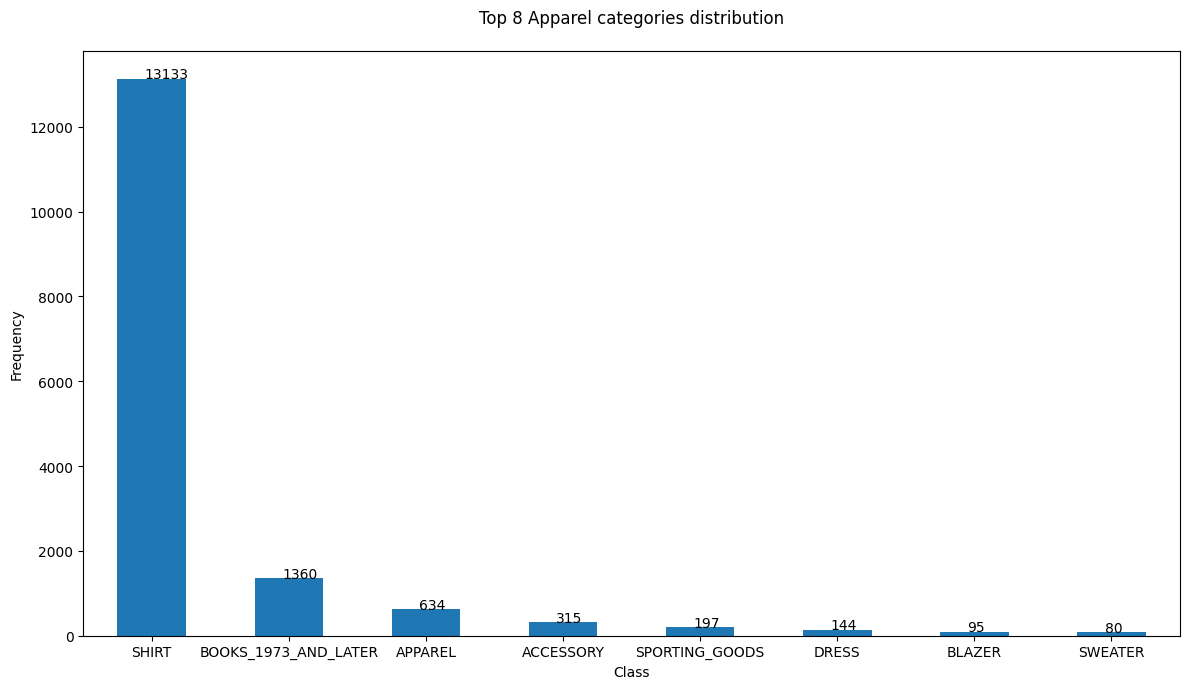

In [ ]:
# Creating a plot to check class distribution
plt.figure(figsize=(12, 7))

# Get the top 10 classes by frequency
top_classes = data['product_type_name'].value_counts().nlargest(8)

# Plotting the top 10 classes
ax = top_classes.plot(kind='bar', rot=0)

plt.title("Top 8 Apparel categories distribution", pad=20)  # Add some space between title and plot
plt.xlabel("Class")
plt.ylabel("Frequency")

# Adding count above the bars
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 6))

plt.tight_layout()  # Adjust layout to make titles visible
plt.show()


# Text Based Recommendation

# Text Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Remove stopwords and tokenize text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]  # Remove stopwords and non-alphanumeric tokens
    return " ".join(filtered_tokens)

# Apply text preprocessing
data['title'] = data['title'].apply(preprocess_text)
data['product_type_name'] = data['product_type_name'].apply(preprocess_text)

# Display the preprocessed text
print(data[['title', 'product_type_name']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                               title product_type_name
0  featherlite ladies long sleeve stain resistant...             shirt
1  women unique 100 cotton special olympics world...             shirt
2  featherlite ladies moisture free mesh sport sh...             shirt
3  supernatural chibis sam dean castiel neck fema...             shirt
4  fifth degree womens gold foil graphic tees jun...             shirt


In [ ]:
pd.set_option('display.max_colwidth', None)

data

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        asin  \
0                 0             0             0           4  B004GSI2OS   
1                 1             1             1           6  B012YX2ZPI   
2                 2             2             2          15  B003BSRPB0   
3                 3             3             3          27  B014ICEJ1Q   
4                 5             5             5          46  B01NACPBG2   
...             ...           ...           ...         ...         ...   
16384         17538         17538         17588      183081  B01MRV2IFS   
16385         17539         17539         17589      183092  B01LY4QWLF   
16386         17540         17540         17590      183096  B07167SCNH   
16387         17541         17541         17591      183101  B07575N2WX   
16388         17542         17542         17592      183120  B01NCO06S0   

                             brand              color  \
0                      FeatherLite  Onyx Black/ Stone   
1      HX-Kingdom Fashion T-shirts              White   
2                      FeatherLite              White   
3                            FNC7C             Purple   
4                     Fifth Degree              Black   
...                            ...                ...   
16384                      YueLian              Black   
16385              Vintage America              White   
16386             Tart Collections              Black   
16387                      Soprano               Gray   
16388                  Faded Glory          Blue/Grey   

                                                                 medium_image_url  \
0        https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg   
1        https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg   
2      https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg   
3        https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg   
4      https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg   
...                                                                           ...   
16384  https://images-na.ssl-images-amazon.com/images/I/41%2BtEUMOzUL._SL160_.jpg   
16385    https://images-na.ssl-images-amazon.com/images/I/41IGij8dDqL._SL160_.jpg   
16386  https://images-na.ssl-images-amazon.com/images/I/41Im-mnGE%2BL._SL160_.jpg   
16387    https://images-na.ssl-images-amazon.com/images/I/41WRn2M14JL._SL160_.jpg   
16388  https://images-na.ssl-images-amazon.com/images/I/41RHS5%2BbB7L._SL160_.jpg   

      product_type_name  \
0                 shirt   
1                 shirt   
2                 shirt   
3                 shirt   
4                 shirt   
...                 ...   
16384             shirt   
16385             shirt   
16386             shirt   
16387             shirt   
16388             shirt   

                                                                                    title  \
0       featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone   
1                  women unique 100 cotton special olympics world games 2015 white size l   
2                                 featherlite ladies moisture free mesh sport shirt white   
3                               supernatural chibis sam dean castiel neck female purple l   
4      fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l   
...                                                                                   ...   
16384                 yuelian women chiffon short sleeves sun protection outerwear blouse   
16385                            vintage america women large lace collared blouse white l   
16386                                       tart womens collections ann wrap top xs black   
16387                                                  soprano womens small tank top gray   
16388                                    faded glory

# Function to dispaly Image

In [ ]:
def display_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to plot cosine similarity heatmap between words

In [ ]:
# Function to plot cosine similarity heatmap between words
def plot_cosine_similarity_heatmap(input_product, similar_product, ax=None):
    input_tokens = input_product.split()
    similar_tokens = similar_product.split()

    # Calculate cosine similarity between words
    cosine_sim = np.zeros((len(input_tokens), len(similar_tokens)))
    for i, input_word in enumerate(input_tokens):
        for j, similar_word in enumerate(similar_tokens):
            if input_word == similar_word:
                cosine_sim[i, j] = 1  # If words are the same, set similarity to 1

    # Plot heatmap
    if ax is None:
        ax = plt.gca()
    sns.heatmap(cosine_sim, annot=True, cmap='binary', xticklabels=similar_tokens, yticklabels=input_tokens, ax=ax)
    ax.set_xlabel('Similar Product Words')
    ax.set_ylabel('Input Product Words')
    ax.set_title('Cosine Similarity between Words')

# Calculate Cosine Similarity

In [ ]:
def calculate_cosine_similarity(features):

    cosine_similarity_matrix = cosine_similarity(features)
    return pd.DataFrame(cosine_similarity_matrix, index=data['title'], columns=data['title'])

# Get the top 10 most similar products to the input product.


In [ ]:
def get_top_similar_products(input_product_index, similarity_df):

    return similarity_df.iloc[input_product_index].sort_values(ascending=False)[1:11]


#    Print the top 10 most similar products to the input product along with heatmap and image.


In [ ]:
def print_top_similar_products(input_product, top_10, data):

    print(f'Top 10 similar products to {input_product}:')
    for title, score in top_10.items():
        print('=' * 80)
        print('ASIN:', data.loc[data['title'] == title, 'asin'].iloc[0])
        print('Brand:', data.loc[data['title'] == title, 'brand'].iloc[0])
        print('Title:', title)
        print('Cosine similarity with the query product:', score)
        print('-' * 80)

        # Create subplots layout
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot cosine similarity heatmap
        plot_cosine_similarity_heatmap(input_product, title, ax=axes[0])

        # Display product image
        display_img(data.loc[data['title'] == title, 'medium_image_url'].iloc[0])

        plt.show()



#    Function to plot a heatmap of Euclidean distances between words in two product titles.


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_euclidean_distance_heatmap(input_product, similar_product, ax=None):
    input_tokens = input_product.split()
    similar_tokens = similar_product.split()

    # Calculate Euclidean distance between words
    euclidean_dist = np.zeros((len(input_tokens), len(similar_tokens)))
    for i, input_word in enumerate(input_tokens):
        for j, similar_word in enumerate(similar_tokens):
            euclidean_dist[i, j] = np.linalg.norm(np.array([i, j]))  # Euclidean distance calculation

    # Plot heatmap
    if ax is None:
        ax = plt.gca()
    sns.heatmap(euclidean_dist, annot=True, cmap='binary', xticklabels=similar_tokens, yticklabels=input_tokens, ax=ax)
    ax.set_xlabel('Similar Product Words')
    ax.set_ylabel('Input Product Words')
    ax.set_title('Euclidean Distance between Words')




#    Function to calculate the Euclidean distance matrix between product features.


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def calculate_euclidean_distance_matrix(title_features):

    euclidean_distance_matrix = euclidean_distances(title_features)
    return euclidean_distance_matrix

#    Function to get the top 10 most similar products to the input product based on Euclidean distances.


In [ ]:
def get_top_10_similar_products_euclidean(distance_df, input_product):

    input_product_index = distance_df.index.get_loc(input_product)
    top_10 = distance_df.iloc[input_product_index].sort_values()[1:11]
    return top_10

#    Print the top 10 most similar products to the input product along with heatmap and image using Euclidean distance.


In [ ]:
def print_top_10_similar_products_euclidean(input_product, top_10, data):
    """
    Print the top 10 most similar products to the input product along with heatmap and image using Euclidean distance.
    """
    print(f'Top 10 similar products to {input_product}:')
    for title, score in top_10.items():
        print('=' * 80)
        print('ASIN:', data.loc[data['title'] == title, 'asin'].iloc[0])
        print('Brand:', data.loc[data['title'] == title, 'brand'].iloc[0])
        print('Title:', title)
        print('Euclidean similarity with the query product:', score)
        print('-' * 80)

        # Create subplots layout
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot Euclidean distance heatmap
        plot_euclidean_distance_heatmap(input_product, title, ax=axes[0])

        # Display product image
        display_img(data.loc[data['title'] == title, 'medium_image_url'].iloc[0])

        plt.show()


# Cosine Similarity Based model


# Bag Of Words

Enter a product you like: featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone
Top 10 similar products to featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone:
ASIN: B004GSN1EE
Brand: FeatherLite
Title: ladies long sleeve stain resistant tapered twill shirt xl onyx black stone
Cosine similarity with the query product: 0.8333333333333336
--------------------------------------------------------------------------------


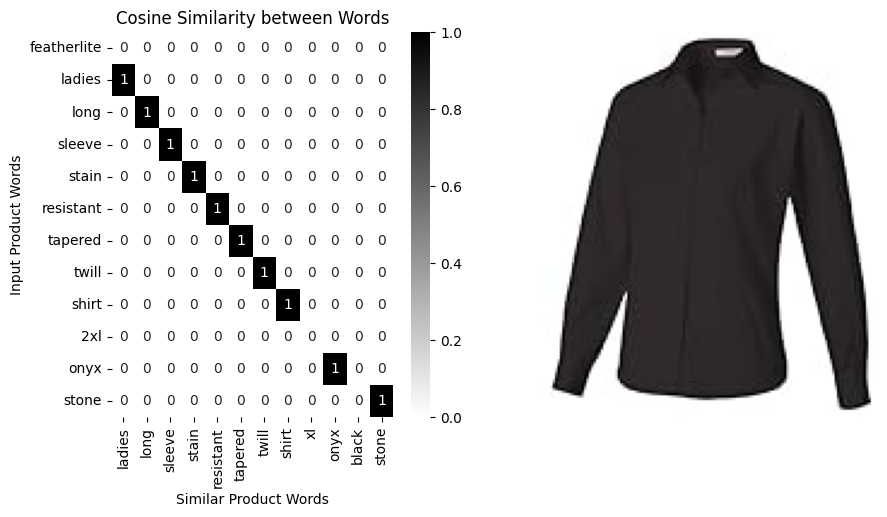

ASIN: B003BTL8EY
Brand: FeatherLite
Title: featherlite ladies long sleeve stain resistant tapered twill shirt sandalwoo
Cosine similarity with the query product: 0.8215838362577492
--------------------------------------------------------------------------------


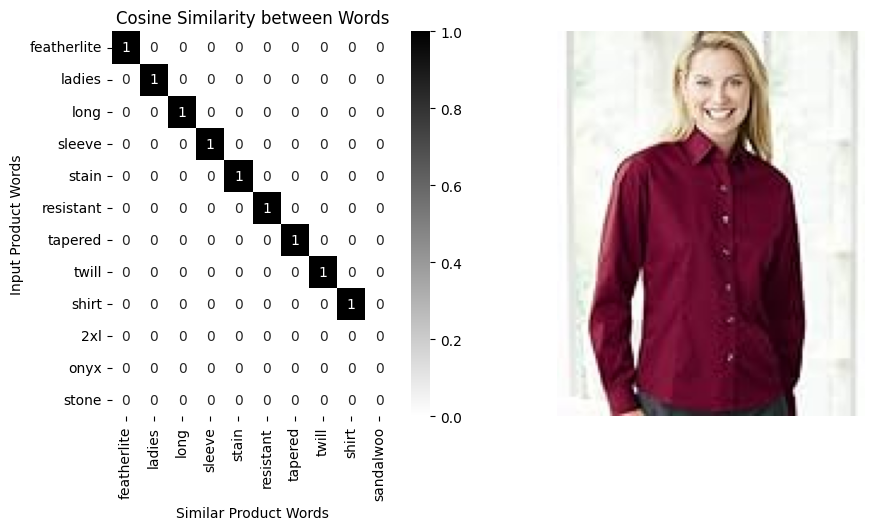

ASIN: B00139HZFU
Brand: FeatherLite
Title: featherlite ladies long sleeve stain resistant tapered twill shirt xl nantucket navy
Cosine similarity with the query product: 0.7500000000000002
--------------------------------------------------------------------------------


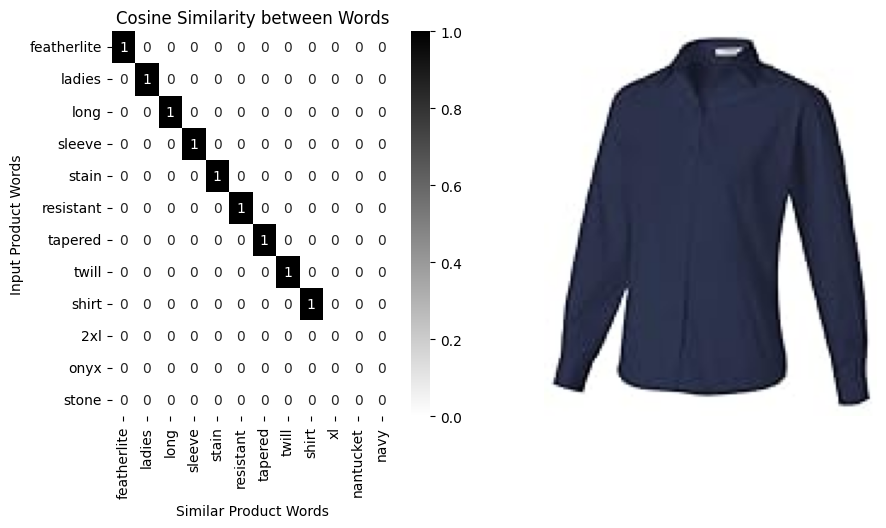

ASIN: B00WDDA534
Brand: Harriton
Title: harriton ladies long sleeve stain release twill shirt stone
Cosine similarity with the query product: 0.6735753140545635
--------------------------------------------------------------------------------


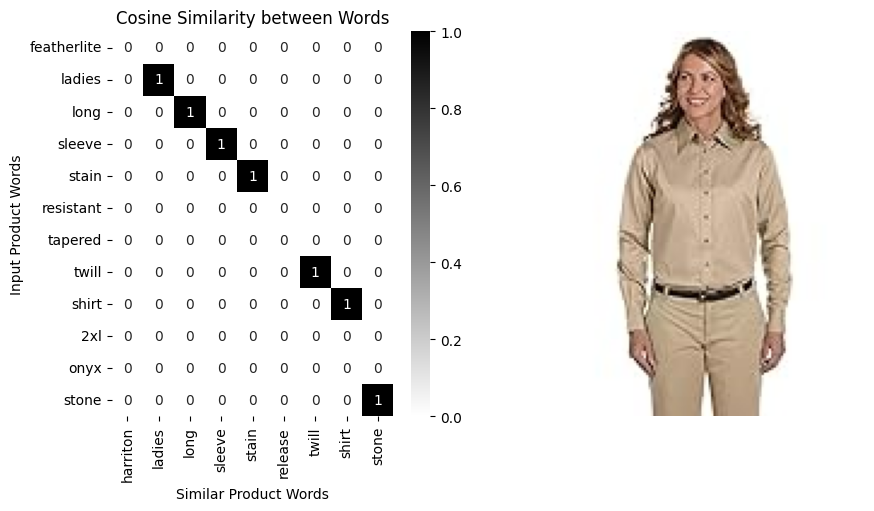

ASIN: B007C0HVRQ
Brand: FeatherLite
Title: featherlite ladies long sleeve tapered twill sandalwood
Cosine similarity with the query product: 0.6546536707079772
--------------------------------------------------------------------------------


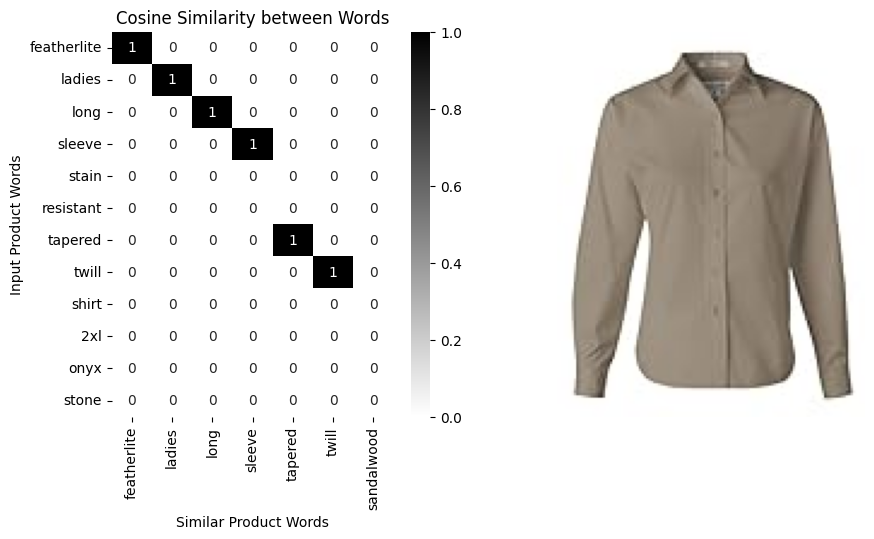

ASIN: B007C0HP72
Brand: FeatherLite
Title: featherlite ladies long sleeve tapered twill pacific blue
Cosine similarity with the query product: 0.6123724356957946
--------------------------------------------------------------------------------


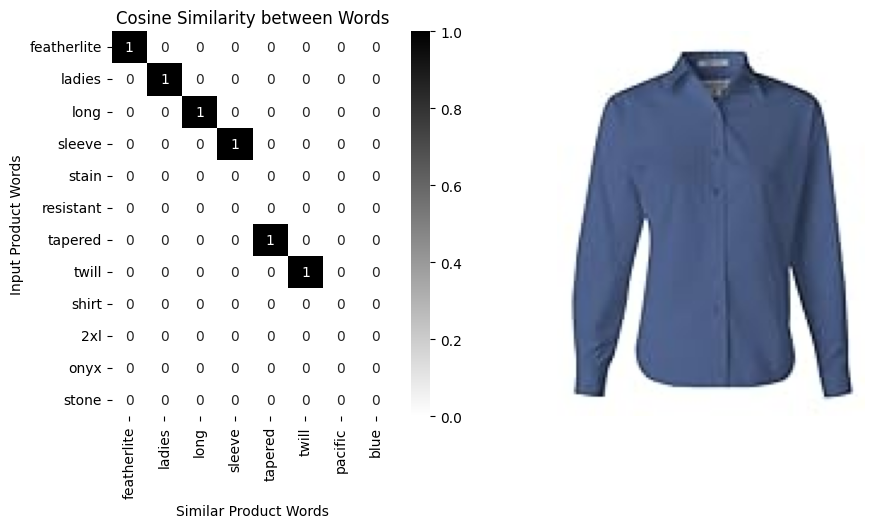

ASIN: B003BSQPW0
Brand: FeatherLite
Title: featherlite ladies long sleeve oxford shirt light blue
Cosine similarity with the query product: 0.5103103630798288
--------------------------------------------------------------------------------


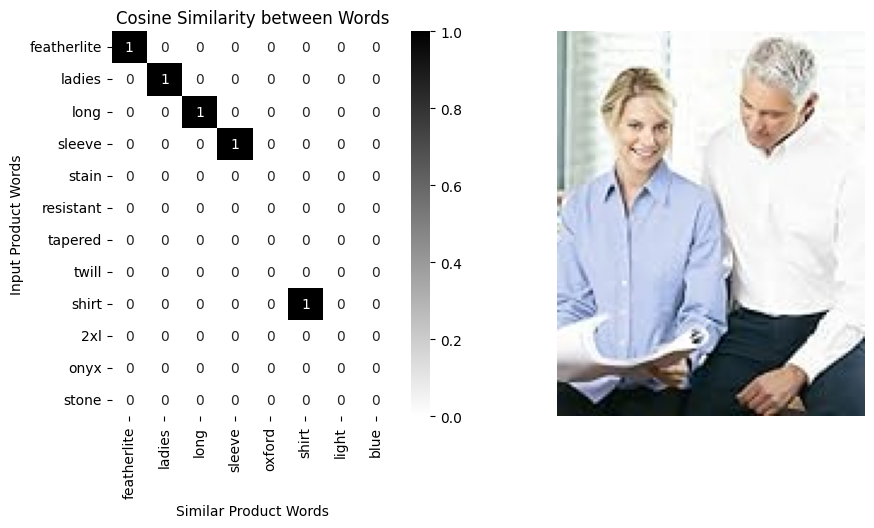

ASIN: B003BSQPX4
Brand: FeatherLite
Title: featherlite ladies long sleeve oxford shirt white small
Cosine similarity with the query product: 0.5103103630798288
--------------------------------------------------------------------------------


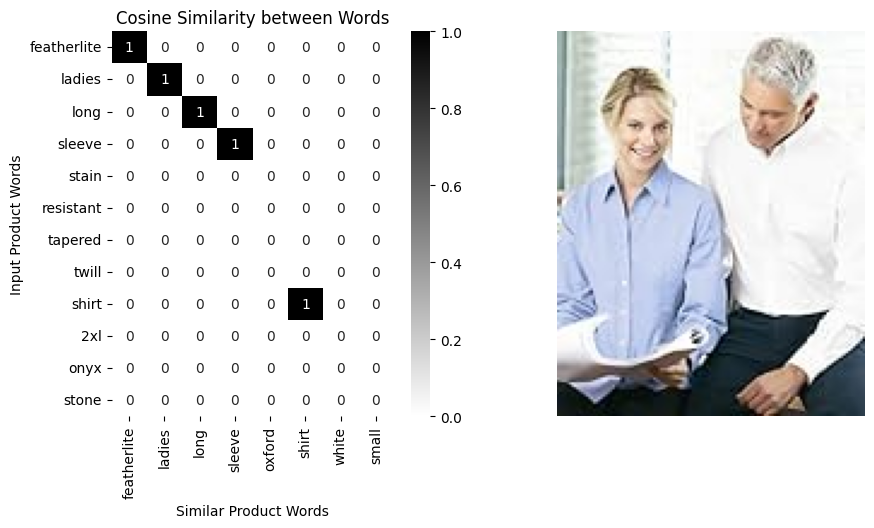

ASIN: B00EFG5HGW
Brand: Clothes Effect
Title: turquoise ladies long sleeve turtleneck shirt
Cosine similarity with the query product: 0.4714045207910318
--------------------------------------------------------------------------------


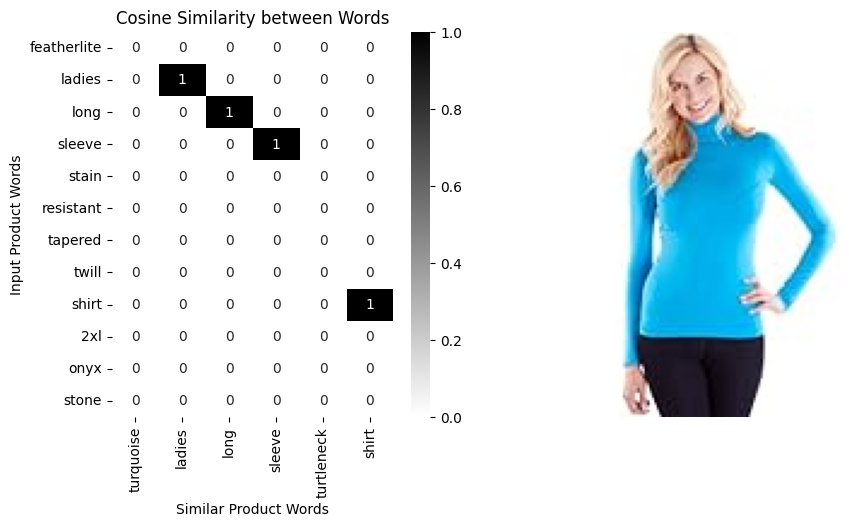

ASIN: B006R7UTU6
Brand: UltraClub
Title: ladies whisper twill shirt french blue 2xl
Cosine similarity with the query product: 0.4364357804719848
--------------------------------------------------------------------------------


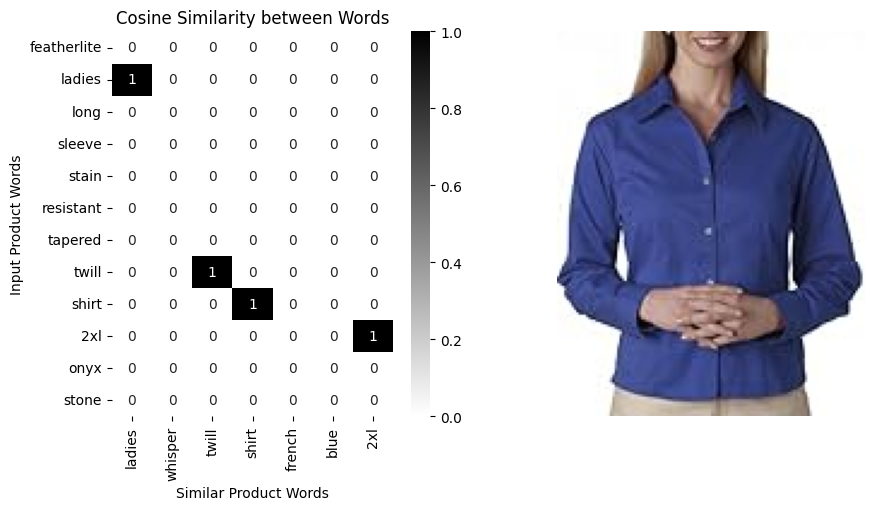

In [ ]:
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])

# Calculate cosine similarity matrix between products
similarity_df = calculate_cosine_similarity(title_features)

# Ask the user for a product they like
input_product = input('Enter a product you like: ')

# Find the index of the input product in the dataset
input_product_index = data[data['title'] == input_product].index[0]

# Get the top 10 most similar products to the input product
top_10 = get_top_similar_products(input_product_index, similarity_df)

# Print the top 10 most similar products to the input product
print_top_similar_products(input_product, top_10, data)

# TF-IDF

Enter a product you like: featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone
Top 10 similar products to featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone:
ASIN: B004GSN1EE
Brand: FeatherLite
Title: ladies long sleeve stain resistant tapered twill shirt xl onyx black stone
Cosine similarity with the query product: 0.8815600891386742
--------------------------------------------------------------------------------


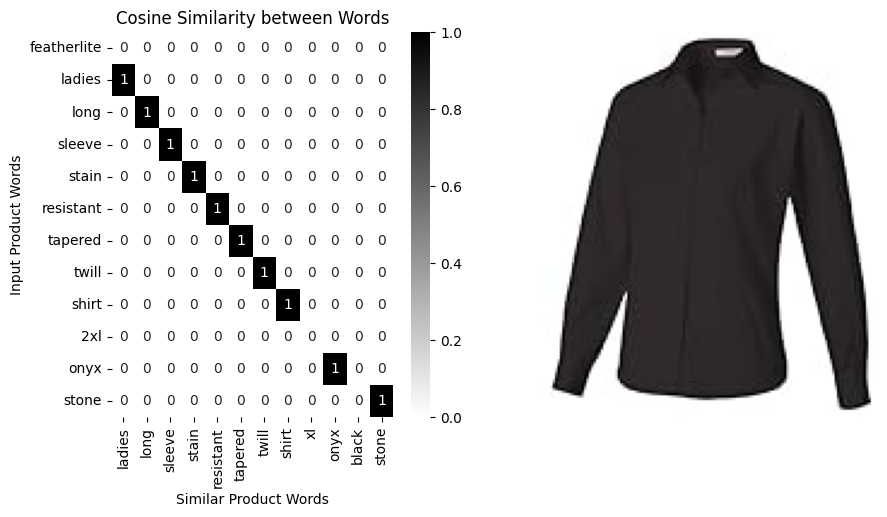

ASIN: B003BTL8EY
Brand: FeatherLite
Title: featherlite ladies long sleeve stain resistant tapered twill shirt sandalwoo
Cosine similarity with the query product: 0.7370256613115889
--------------------------------------------------------------------------------


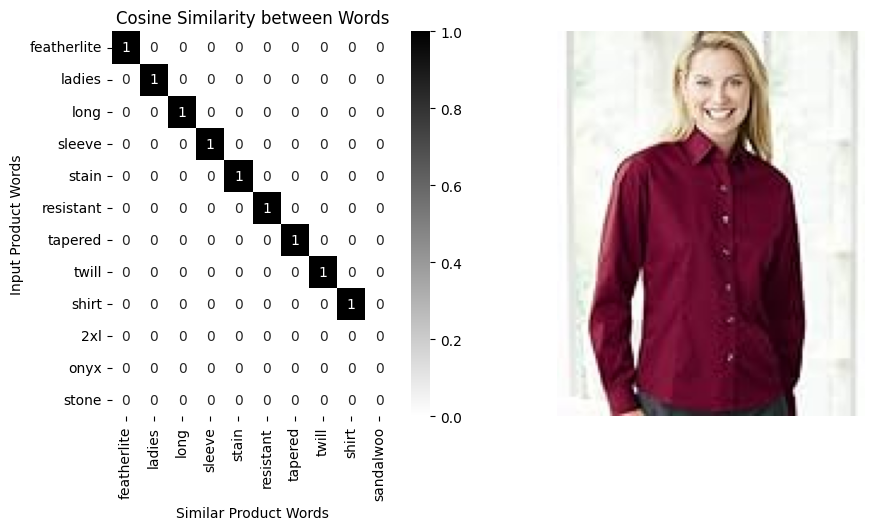

ASIN: B00139HZFU
Brand: FeatherLite
Title: featherlite ladies long sleeve stain resistant tapered twill shirt xl nantucket navy
Cosine similarity with the query product: 0.7151732018344644
--------------------------------------------------------------------------------


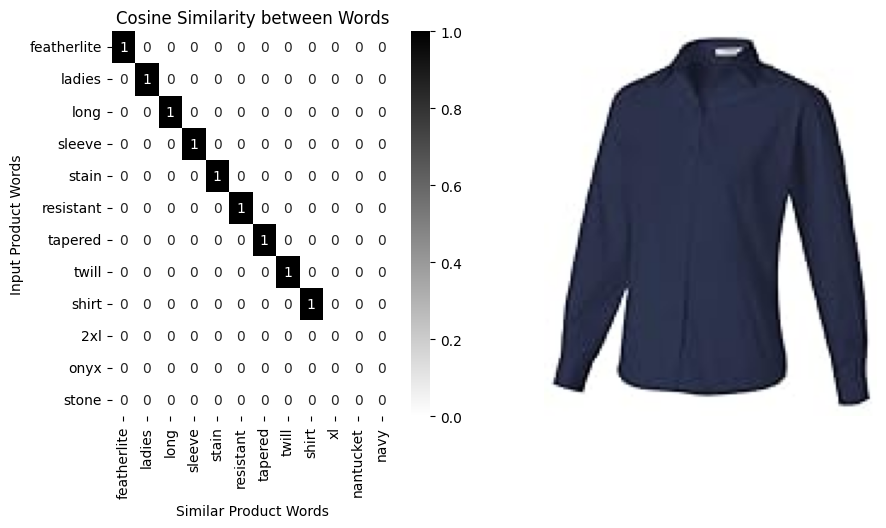

ASIN: B007C0HP72
Brand: FeatherLite
Title: featherlite ladies long sleeve tapered twill pacific blue
Cosine similarity with the query product: 0.5568908739946691
--------------------------------------------------------------------------------


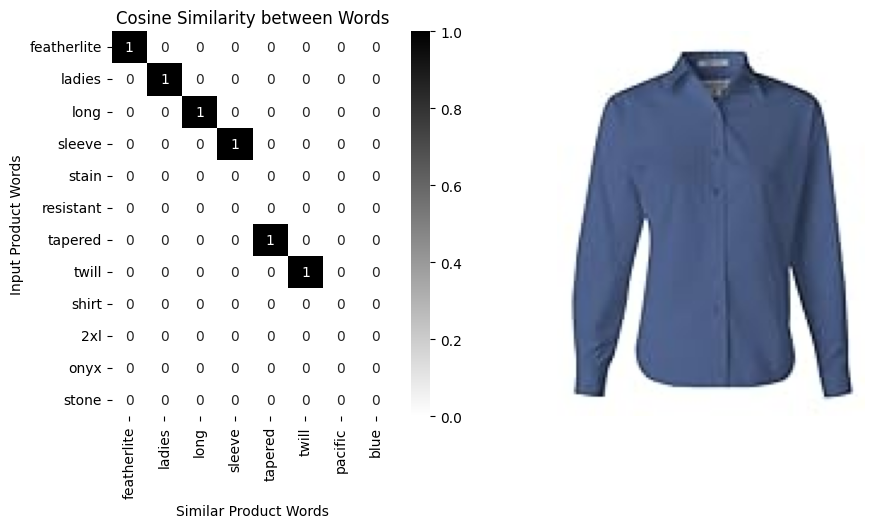

ASIN: B007C0HVRQ
Brand: FeatherLite
Title: featherlite ladies long sleeve tapered twill sandalwood
Cosine similarity with the query product: 0.5403233834715232
--------------------------------------------------------------------------------


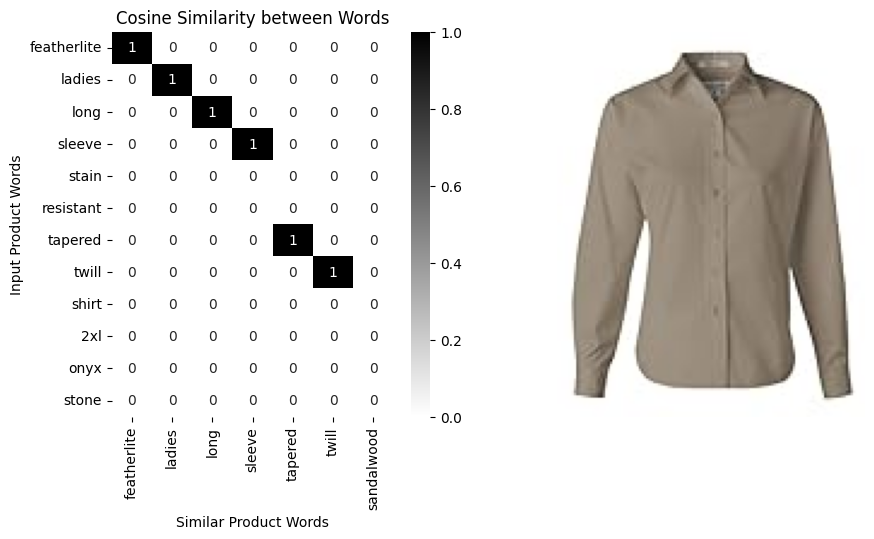

ASIN: B00WDDA534
Brand: Harriton
Title: harriton ladies long sleeve stain release twill shirt stone
Cosine similarity with the query product: 0.5099061813694046
--------------------------------------------------------------------------------


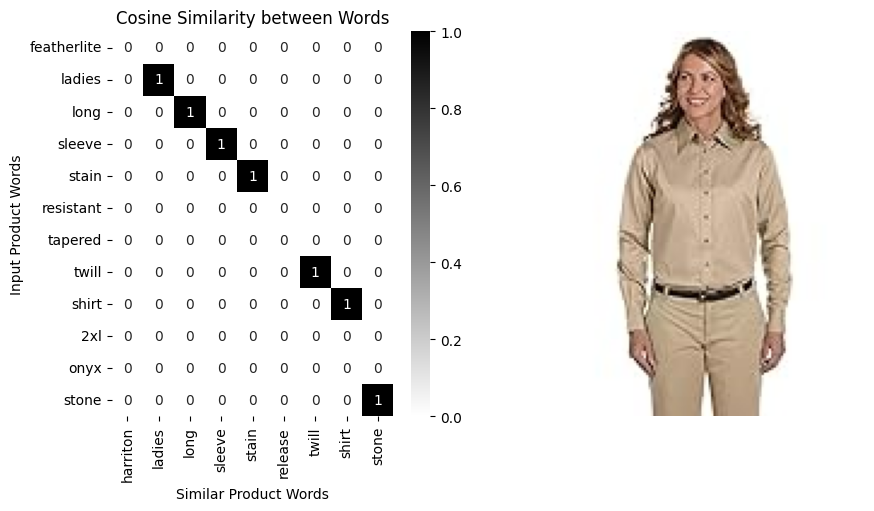

ASIN: B01KVKQLL0
Brand: Clique/New Wave
Title: clique women stain resistant twill button shirt navy
Cosine similarity with the query product: 0.4739039625758027
--------------------------------------------------------------------------------


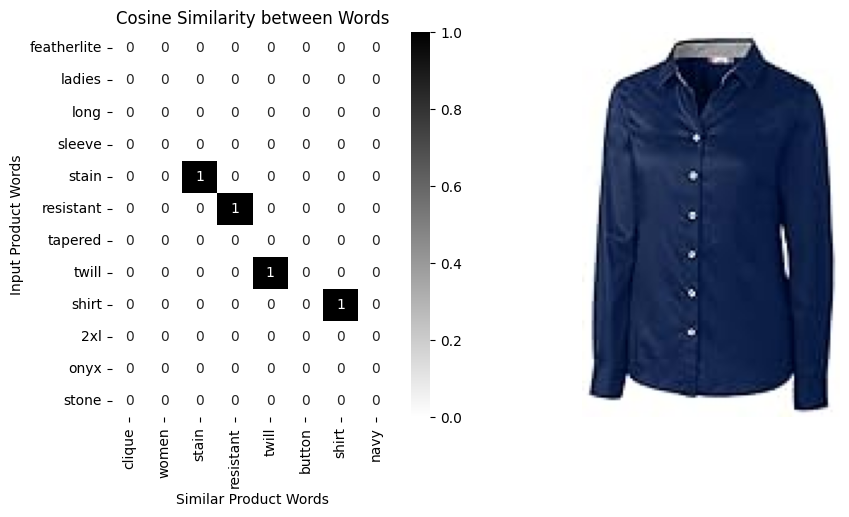

ASIN: B01KVKQPX4
Brand: Clique/New Wave
Title: wave lqw00010 womens bergen stain resistant twill shirts navy xxl
Cosine similarity with the query product: 0.3547175509726537
--------------------------------------------------------------------------------


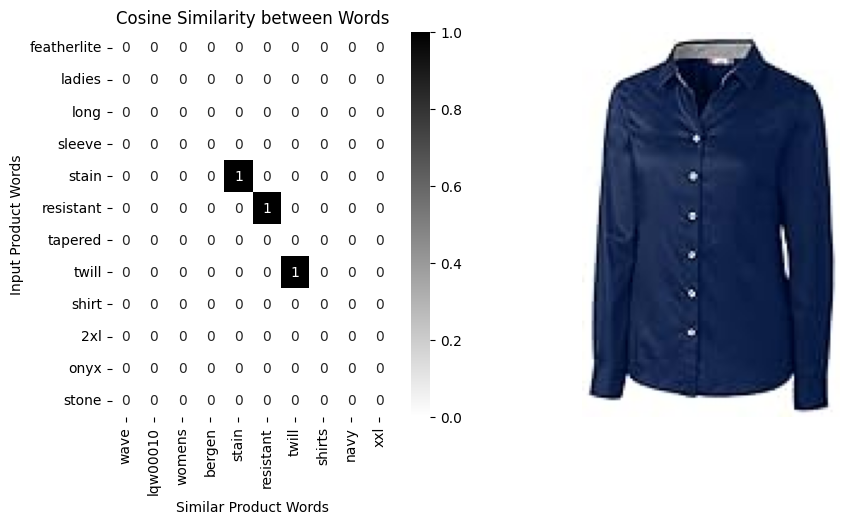

ASIN: B003BSQPX4
Brand: FeatherLite
Title: featherlite ladies long sleeve oxford shirt white small
Cosine similarity with the query product: 0.35143496395761364
--------------------------------------------------------------------------------


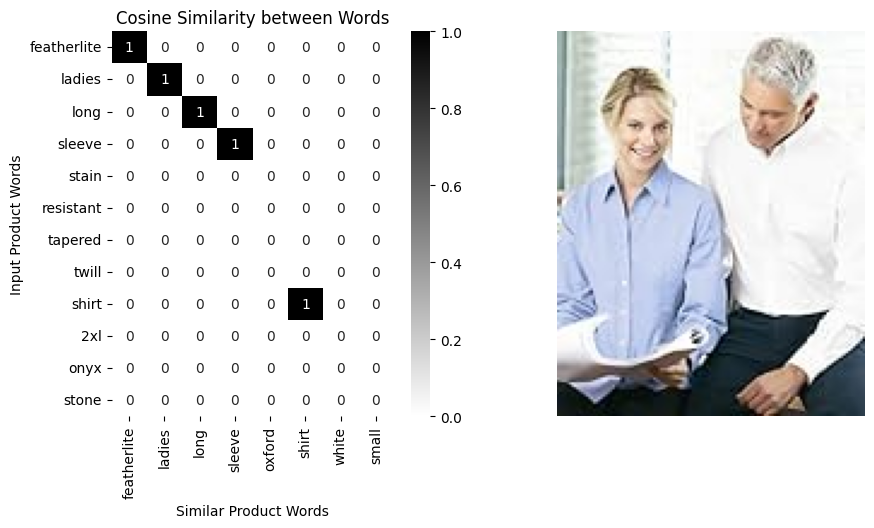

ASIN: B003BSQPW0
Brand: FeatherLite
Title: featherlite ladies long sleeve oxford shirt light blue
Cosine similarity with the query product: 0.32913233131077946
--------------------------------------------------------------------------------


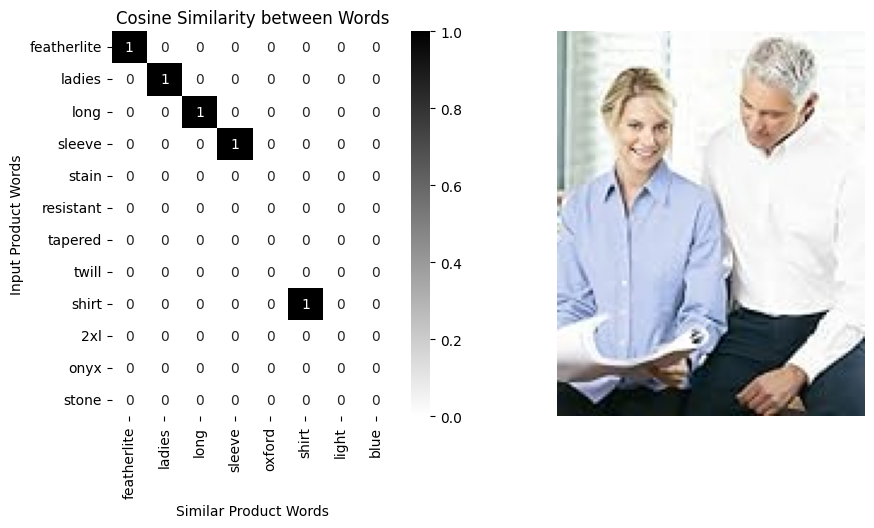

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object to transform the product information into a Tf-idf representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(data['title'])

# Calculate cosine similarity matrix between products
cosine_similarity_matrix_tfidf = cosine_similarity(tfidf_features)

# Create DataFrame with cosine similarity scores
similarity_df_tfidf = pd.DataFrame(cosine_similarity_matrix_tfidf, index=data['title'], columns=data['title'])

# Ask the user for a product they like
input_product_tfidf = input('Enter a product you like: ')

# Find the index of the input product in the dataset
input_product_index_tfidf = data[data['title'] == input_product_tfidf].index[0]

# Get the top 10 most similar products to the input product
top_10_tfidf = get_top_similar_products(input_product_index_tfidf, similarity_df_tfidf)

# Print the top 10 most similar products to the input product
print_top_similar_products(input_product_tfidf, top_10_tfidf, data)


# Word To Vector

Enter a product you like: featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone
Top 10 similar products to featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx stone:
ASIN: B00B698YUW
Brand: Fruit of the Loom
Title: fruit loom ladies long sleeve oxford shirt xxl oxford grey
Cosine similarity with the query product: 0.9993929862976074
--------------------------------------------------------------------------------


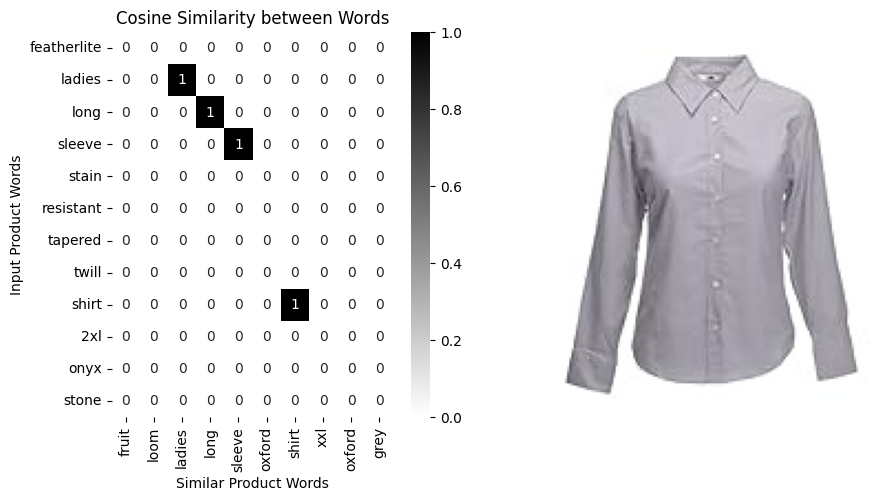

ASIN: B0184ROIQ2
Brand: Elizabeth McKay
Title: elizabeth mckay women long sleeve jojo polo chocolate
Cosine similarity with the query product: 0.9993679523468018
--------------------------------------------------------------------------------


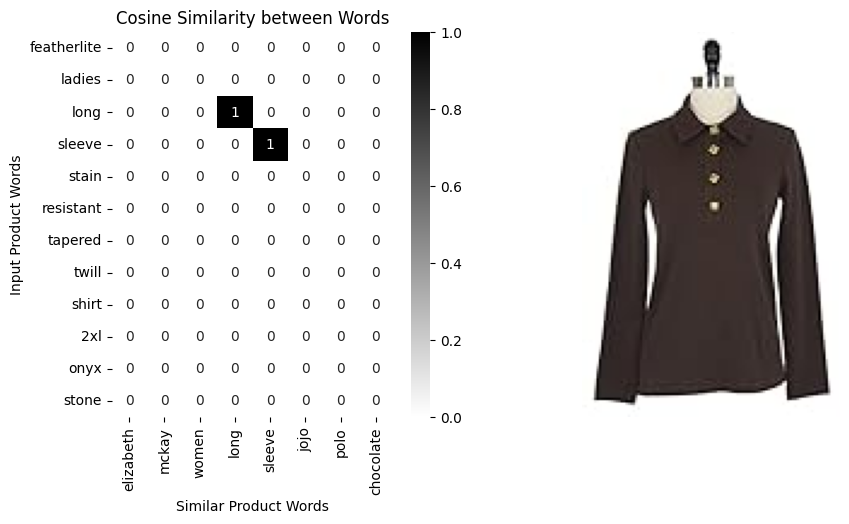

ASIN: B00RIB1RF6
Brand: Ash City
Title: il migliore 77004 ladies wrinkle resistant long sleeve oxford shirt white 701
Cosine similarity with the query product: 0.9993166923522949
--------------------------------------------------------------------------------


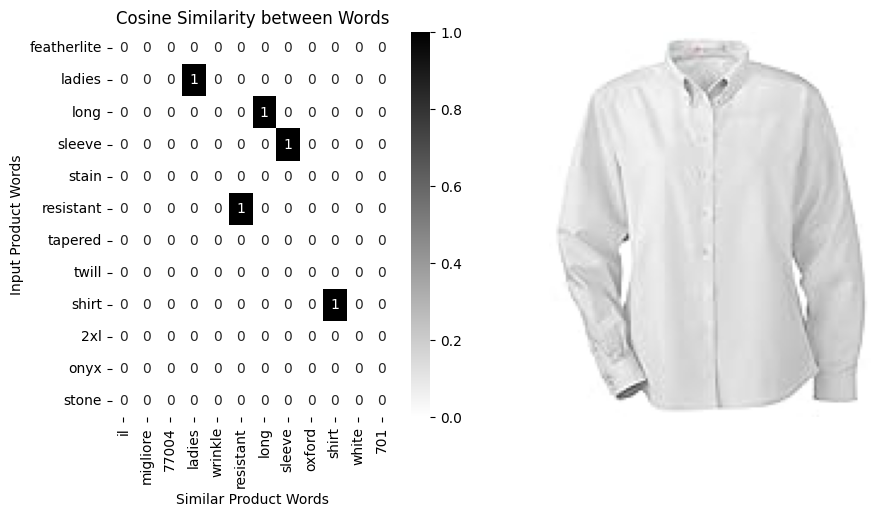

ASIN: B004ZUNVMU
Brand: Russell Athletic
Title: russell women pique cotton short sleeve polo shirt sky
Cosine similarity with the query product: 0.9992244839668274
--------------------------------------------------------------------------------


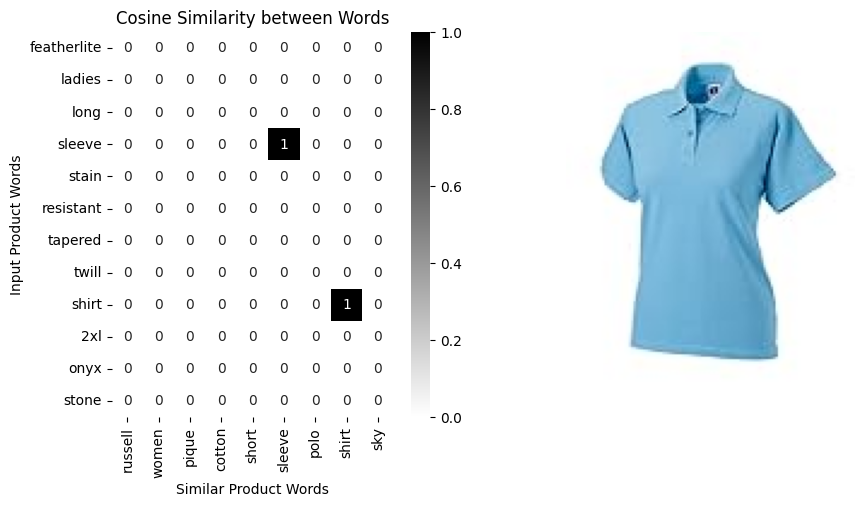

ASIN: B00XOBBHIQ
Brand: Asquith And Fox
Title: asquith fox plain short sleeve polo shirt burgundy
Cosine similarity with the query product: 0.9992135763168335
--------------------------------------------------------------------------------


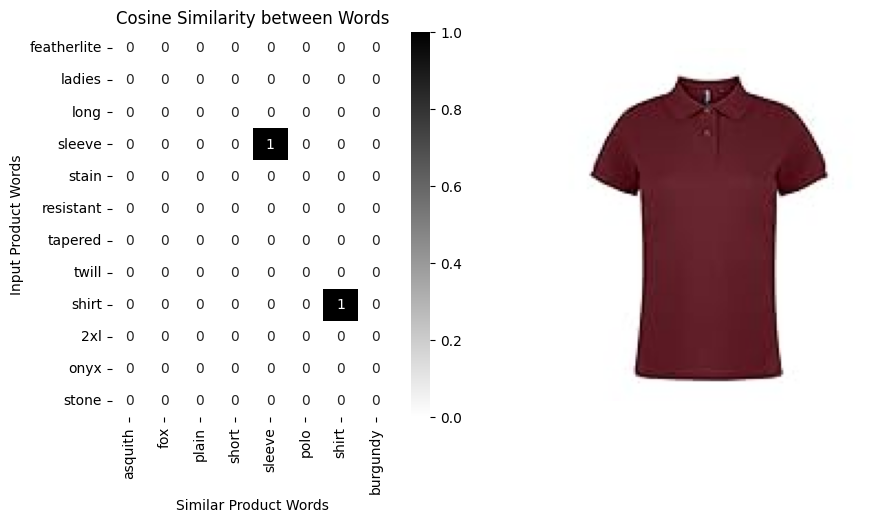

ASIN: B00IKF5OP8
Brand: North End Sport Red
Title: north end ladies performance short sleeve shirt 78675 white
Cosine similarity with the query product: 0.9990320205688477
--------------------------------------------------------------------------------


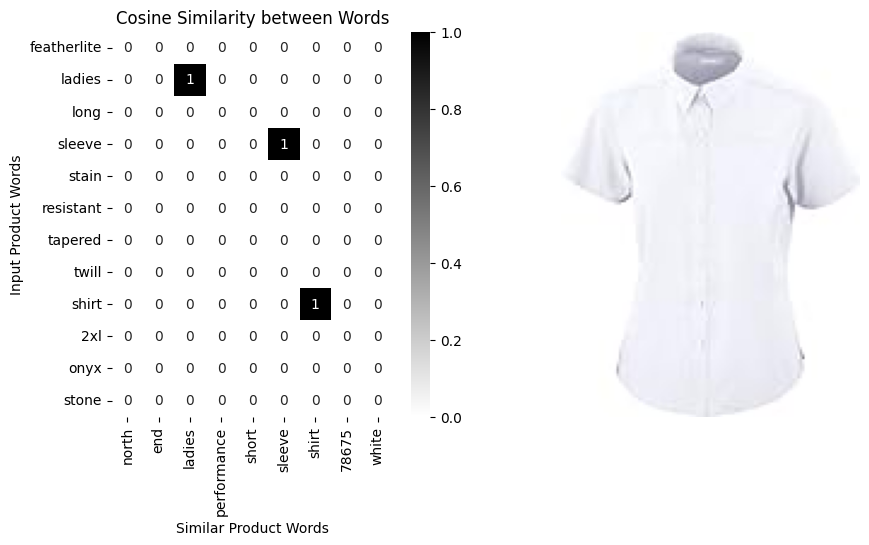

ASIN: B01EIGOU34
Brand: Van Heusen
Title: van heusen ladies long sleeve easy care feather stripe dress
Cosine similarity with the query product: 0.9989849925041199
--------------------------------------------------------------------------------


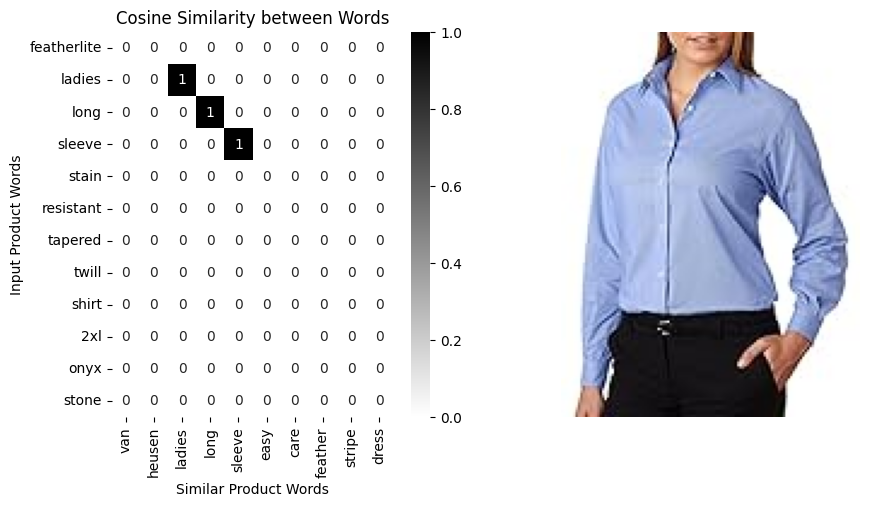

ASIN: B00JHSP6BE
Brand: Sharkskin
Title: sharkskin ladies performance wear long sleeve shirt orange 12
Cosine similarity with the query product: 0.998982310295105
--------------------------------------------------------------------------------


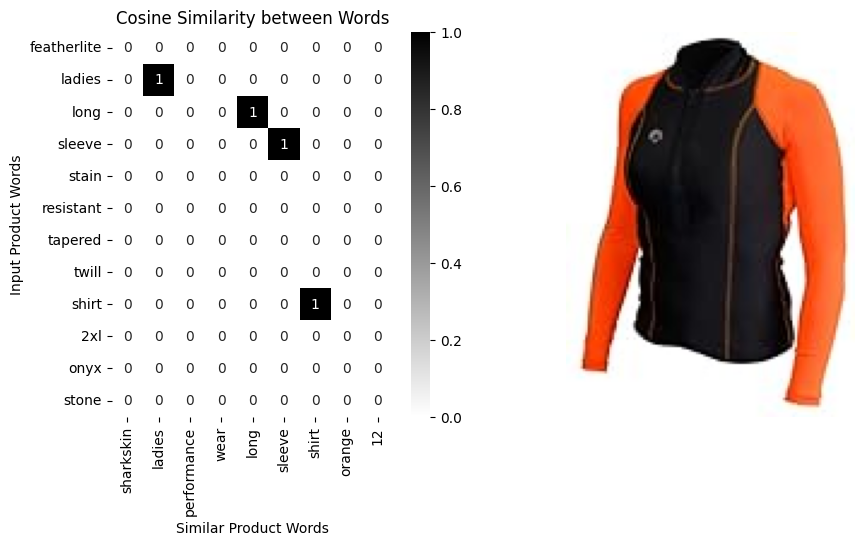

ASIN: B004IAH0UQ
Brand: GIII for Her by Alyssa Milano
Title: missouri tigers women long sleeve polo alyssa milano
Cosine similarity with the query product: 0.998878538608551
--------------------------------------------------------------------------------


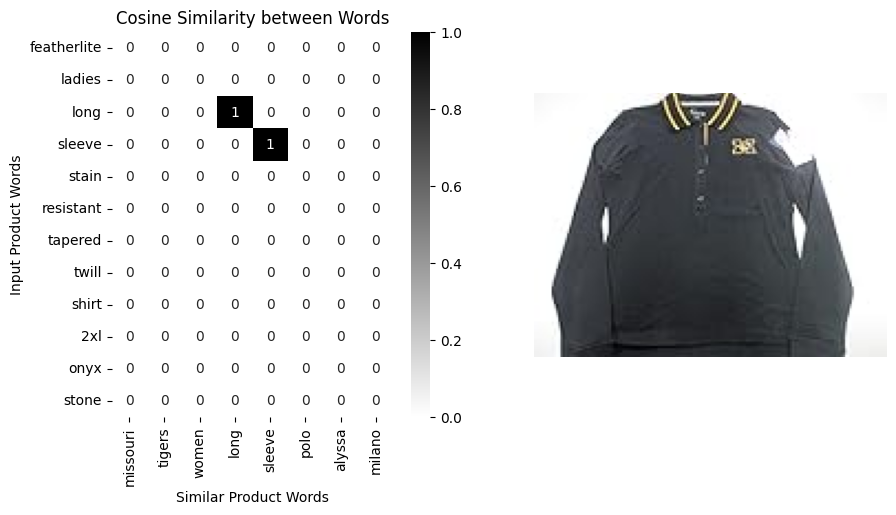

ASIN: B00WDDA534
Brand: Harriton
Title: harriton ladies long sleeve stain release twill shirt stone
Cosine similarity with the query product: 0.9988633394241333
--------------------------------------------------------------------------------


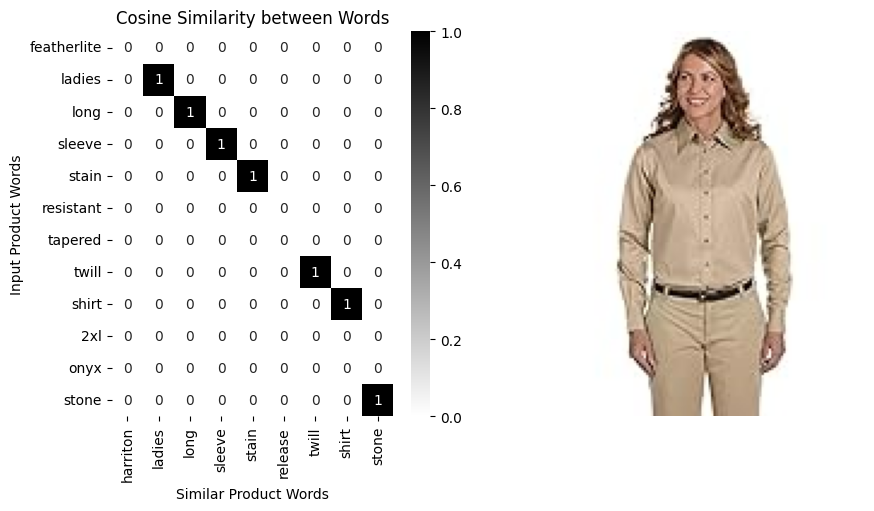

In [ ]:
from gensim.models import Word2Vec

# Tokenize the text
tokenized_text = [text.split() for text in data['title']]

# Train Word2Vec model
model_w2v = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Vectorize the text data
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model_w2v.wv[word] for word in words if word in model_w2v.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

# Calculate cosine similarity matrix between products
cosine_similarity_matrix_w2v = cosine_similarity([vectorize(title) for title in data['title']])

# Create DataFrame with cosine similarity scores
similarity_df_w2v = pd.DataFrame(cosine_similarity_matrix_w2v, index=data['title'], columns=data['title'])

# Ask the user for a product they like
input_product_w2v = input('Enter a product you like: ')

# Find the index of the input product in the dataset
input_product_index_w2v = data[data['title'] == input_product_w2v].index[0]

# Get the top 10 most similar products to the input product
top_10_w2v = get_top_similar_products(input_product_index_w2v, similarity_df_w2v)

# Print the top 10 most similar products to the input product
print_top_similar_products(input_product_w2v, top_10_w2v, data)


# ROC-AUC Curve

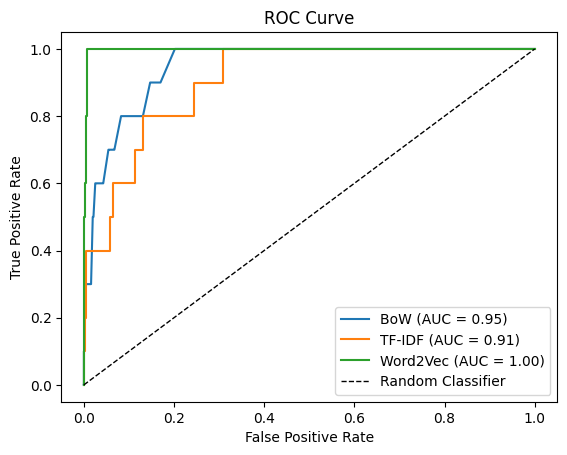

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Define the true labels (1 for top 10 products, 0 for others)
true_labels = np.zeros(len(data['title']))

# Set the top 10 product indices to 1
top_10_indices = [data[data['title'] == title].index[0] for title in top_10.index]
top_10_tfidf_indices = [data[data['title'] == title].index[0] for title in top_10_tfidf.index]
top_10_w2v_indices = [data[data['title'] == title].index[0] for title in top_10_w2v.index]

# Assign correct true labels
true_labels[top_10_indices] = 1

# Get the predicted scores from the cosine similarity matrices
predicted_scores_bow = similarity_df.loc[input_product, :]
predicted_scores_tfidf = similarity_df_tfidf.loc[input_product_tfidf, :]
predicted_scores_w2v = similarity_df_w2v.loc[input_product_w2v, :]

# Generate the ROC curve and calculate AUC for each model
fpr_bow, tpr_bow, _ = roc_curve(true_labels, predicted_scores_bow)
auc_bow = auc(fpr_bow, tpr_bow)

fpr_tfidf, tpr_tfidf, _ = roc_curve(true_labels, predicted_scores_tfidf)
auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

fpr_w2v, tpr_w2v, _ = roc_curve(true_labels, predicted_scores_w2v)
auc_w2v = auc(fpr_w2v, tpr_w2v)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_bow, tpr_bow, label=f'BoW (AUC = {auc_bow:.2f})')
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF (AUC = {auc_tfidf:.2f})')
plt.plot(fpr_w2v, tpr_w2v, label=f'Word2Vec (AUC = {auc_w2v:.2f})')

# Plot the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

# Label and display the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


# Euclidian Distance based model


# Bag Of Words

In [ ]:
input_product = input('Enter a product you like: ')

# BOW model
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])

# Calculate Euclidean distance matrix between products
euclidean_distance_matrix = calculate_euclidean_distance_matrix(title_features)

# Create DataFrame with Euclidean distance scores
distance_df = pd.DataFrame(euclidean_distance_matrix, index=data['title'], columns=data['title'])

# Get the top 10 most similar products to the input product
top_10 = get_top_10_similar_products_euclidean(distance_df, input_product)

# Print the top 10 most similar products to the input product
print_top_10_similar_products_euclidean(input_product, top_10, data)


Output hidden; open in https://colab.research.google.com to view.

# Tf-IDF

In [ ]:
# Ask the user for a product they like
input_product = input('Enter a product you like: ')

# TF-IDF model
title_vectorizer = TfidfVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])

# Calculate Euclidean distance matrix between products
euclidean_distance_matrix = calculate_euclidean_distance_matrix(title_features)

# Create DataFrame with Euclidean distance scores
distance_df = pd.DataFrame(euclidean_distance_matrix, index=data['title'], columns=data['title'])

# Get the top 10 most similar products to the input product
top_10 = get_top_10_similar_products_euclidean(distance_df, input_product)

# Print the top 10 most similar products to the input product
print_top_10_similar_products_euclidean(input_product, top_10, data)

Output hidden; open in https://colab.research.google.com to view.

# Word2Vector

In [ ]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Ask the user for a product they like
input_product = input('Enter a product you like: ')

# Train Word2Vec model
tokenized_text = [text.split() for text in data['title']]
model_w2v = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Vectorize the text data
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model_w2v.wv[word] for word in words if word in model_w2v.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

# Calculate Euclidean distance matrix between products
euclidean_distance_matrix = calculate_euclidean_distance_matrix([vectorize(title) for title in data['title']])

# Create DataFrame with Euclidean distance scores
distance_df = pd.DataFrame(euclidean_distance_matrix, index=data['title'], columns=data['title'])

# Get the top 10 most similar products to the input product
top_10 = get_top_10_similar_products_euclidean(distance_df, input_product)

# Print the top 10 most similar products to the input product
print_top_10_similar_products_euclidean(input_product, top_10, data)


Output hidden; open in https://colab.research.google.com to view.

# Image Based Recommendation

In [ ]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Getting the images and specifying size

In [ ]:
# parameters setup

imgs_path = "/content/drive/My Drive/DataMining Project/images/"
print(len(os.listdir(imgs_path)))
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

16308


# Loading the VGG16 Model

In [ ]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("number of images:",len(files))

number of images: 16308


# Plotting a single image to analyze it

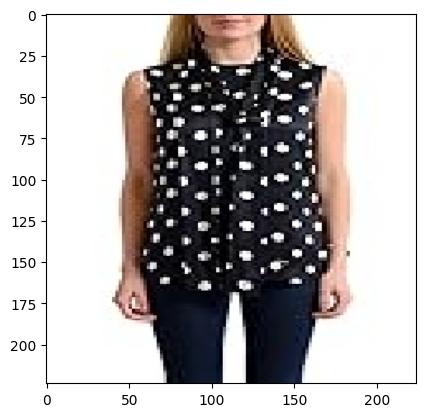

image loaded successfully!


In [ ]:
# load an image in PIL format
import matplotlib.pyplot as plt
original = load_img(files[1], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

# Converting Image to array, then into batch format.

In [ ]:

numpy_image = img_to_array(original)

image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


# Extract 4096 features of the processed image

In [ ]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 1s 891ms/step
features successfully extracted!
number of image features: 4096


array([[0.       , 0.       , 0.       , ..., 0.       , 1.3696041,
        0.       ]], dtype=float32)

# Making the same for all of the images
(Reading them, converting to array, and processing)

In [ ]:
importedImages = []

# Iterate over the first 3000 files in files
for f in files[:1000]:
    filename = f
    asins = [filename.split('.')[0] for filename in files]
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())


# Saving the image arrays as processed_images.npz file on Google Drive

In [ ]:
directory_path = '/content/drive/My Drive/DataMining Project/'

data = np.load(directory_path + 'processed_images.npz')
processed_imgs = data['images']
asin = data['asins']



In [ ]:
np.savez(directory_path + 'processed_images.npz', images=processed_imgs, asins=asins)


# Extracting the features from the images

In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

32/32 [==============================] - 555s 17s/step
features successfully extracted!


(1000, 4096)

# Getting the cosine similarity between the images

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files[:1000], index=files[:1000])
cos_similarities_df.head()

/content/drive/My Drive/DataMining Project/images/B072152NWP.jpg  \
/content/drive/My Drive/DataMining Project/imag...                                           1.000000                  
/content/drive/My Drive/DataMining Project/imag...                                           0.495674                  
/content/drive/My Drive/DataMining Project/imag...                                           0.650913                  
/content/drive/My Drive/DataMining Project/imag...                                           0.488402                  
/content/drive/My Drive/DataMining Project/imag...                                           0.590063                  

                                                    /content/drive/My Drive/DataMining Project/images/B01D6FVFH2.jpg  \
/content/drive/My Drive/DataMining Project/imag...                                           0.495674                  
/content/drive/My Drive/DataMining Project/imag...                                           1.000000                  
/content/drive/My Drive/DataMining Project/imag...                                           0.470122                  
/content/drive/My Drive/DataMining Project/imag...                                           0.477595                  
/content/drive/My Drive/DataMining Project/imag...                                           0.691254                  

                                                    /content/drive/My Drive/DataMining Project/images/B01C4RGSB6.jpg  \
/content/drive/My Drive/DataMining Project/imag...                                           0.650913                  
/content/drive/My Drive/DataMining Project/imag...                                           0.470122                  
/content/drive/My Drive/DataMining Project/imag...                                           1.000000                  
/content/drive/My Drive/DataMining Project/imag...                                           0.452240                  
/content/drive/My Drive/DataMining Project/imag...                                           0.612459                  

                                                    /content/drive/My Drive/DataMining Project/images/B00BR9I35C.jpg  \
/content/drive/My Drive/DataMining Project/imag...                                           0.488402                  
/content/drive/My Drive/DataMining Project/imag...                                           0.477595                  
/content/drive/My Drive/DataMining Project/imag...                                           0.452240                  
/content/drive/My Drive/DataMining Project/imag...                                           1.000000                  
/content/drive/My Drive/DataMining Project/imag...                                           0.614623                  

                                                    /content/drive/My Drive/DataMining Project/images/B014EF93RC.jpg  \
/content/drive/My Drive/DataMining Project/imag...                                           0.590063                  
/content/drive/My Drive/DataMining Project/imag...                                           0.691254                  
/content/drive/My Drive/DataMining Project/imag...                                           0.612459                  
/content/drive/My Drive/DataMining Project/imag...                                           0.614623                  
/content/drive/My Drive/DataMining Project/imag...                                           1.000000                  

                                                    /content/drive/My Drive/DataMining Project/images/B07336B8WY.jpg  \
/content/drive/My Drive/DataMining Project/imag...                                           0.554424                  
/content/drive/My Drive/DataMining Project/imag...                                           0.453855                  
/content/drive/My Drive/DataMining Project/imag...                                     

# Retrieving most similar products including their ASIN and Title

In [ ]:
def retrieve_most_similar_products(given_img, data):
    print("-----------------------------------------------------------------------")
    print("Original product:")
    original_asin = os.path.splitext(os.path.basename(given_img))[0]
    original_title = data[data['asin'] == original_asin]['title'].iloc[0]
    print("ASIN:", original_asin)
    print("Title:", original_title)
    original_img = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original_img)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    closest_imgs_scores = closest_imgs.values
    closest_imgs_asins = closest_imgs.index

    for i in range(len(closest_imgs_asins)):
        asin = os.path.splitext(os.path.basename(closest_imgs_asins[i]))[0]
        print("ASIN:", asin)
        title = data[data['asin'] == asin]['title'].iloc[0]
        print("Title:", title)
        similar_img = load_img(closest_imgs_asins[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(similar_img)
        plt.show()
        print("Similarity score:", closest_imgs_scores[i])


# Plotting the data

-----------------------------------------------------------------------
Original product:
ASIN: B01APYN5AM
Title: Dsqured2 Women's Polka Dot Long Sleeve Button Down Shirt US S IT 40


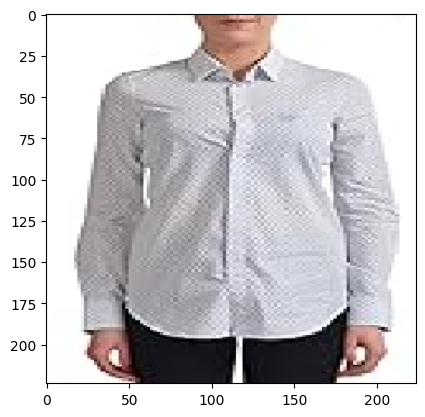

-----------------------------------------------------------------------
Most similar products:
ASIN: B014WD3DHW
Title: Van Heusen Ladies' Long-Sleeve Yarn-Dyed Gingham Check, Periwinkle, Medium


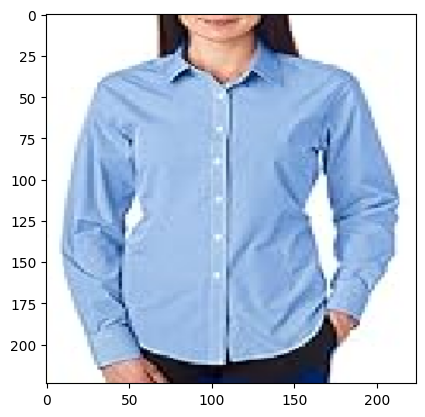

Similarity score: 0.8430914
ASIN: B01758P216
Title: Dsquared2 Women's White Long Sleeve Blouse Shirt US S IT 40


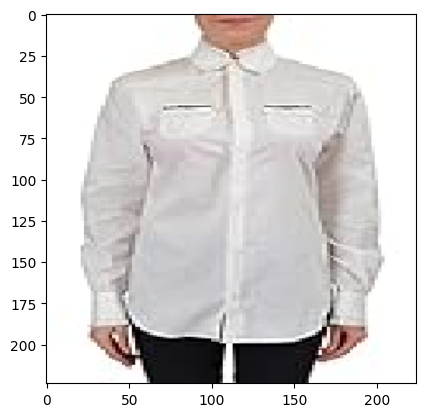

Similarity score: 0.8373095
ASIN: B00TQ6OEMY
Title: Just Cavalli Women's Blue Button Down Shirt Blouse US 4 IT 40


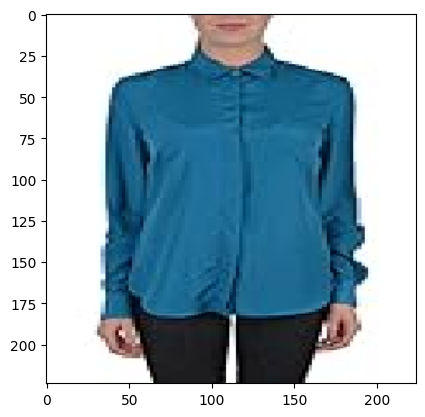

Similarity score: 0.8305861
ASIN: B0038MPIB8
Title: UltraClub Women's Classic Wrinkle-Free Oxford Shirt, Light Blue, X-Large


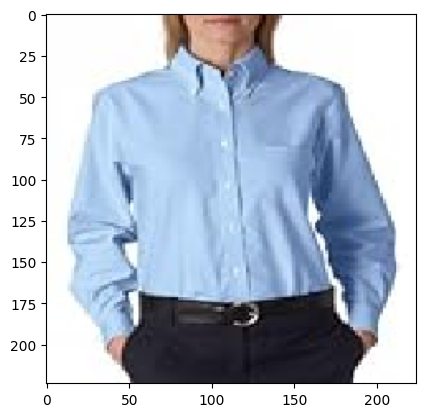

Similarity score: 0.82504195
ASIN: B01H8NDH7E
Title: Van Heusen Women's Wrinkle Free Spread Collar Oxford Shirt, FRENCH BLUE, Small


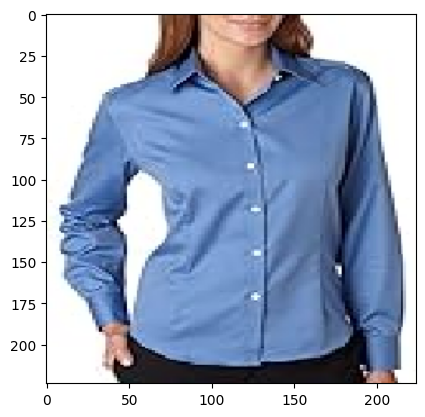

Similarity score: 0.8240273


In [ ]:
retrieve_most_similar_products(files[20], data)


# Performing ResNet50 CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading ResNet50 model

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
feature_extractor_resnet = Model(inputs=resnet_model.input, outputs=resnet_model.layers[-1].output)

# Reading the image arrays from processed_images.npz

In [ ]:
data = np.load(directory_path + 'processed_images.npz')
processed_imgs = data['images']
asin = data['asins']


# Extracting image features

In [ ]:

imgs_features_resnet = feature_extractor_resnet.predict(processed_imgs)
# Flatten the 4D tensor into a 2D array
imgs_features_resnet_flat = imgs_features_resnet.reshape(imgs_features_resnet.shape[0], -1)
# Compute cosine similarities between images
cosSimilarities_resnet = cosine_similarity(imgs_features_resnet_flat)


32/32 [==============================] - 174s 5s/step


# Getting image cosine similarities

In [ ]:
cos_similarities_df_resnet = pd.DataFrame(cosSimilarities_resnet, columns=files[:1000], index=files[:1000])


# Plotting plot comparing cosine similarities between VGG16 and ResNet50

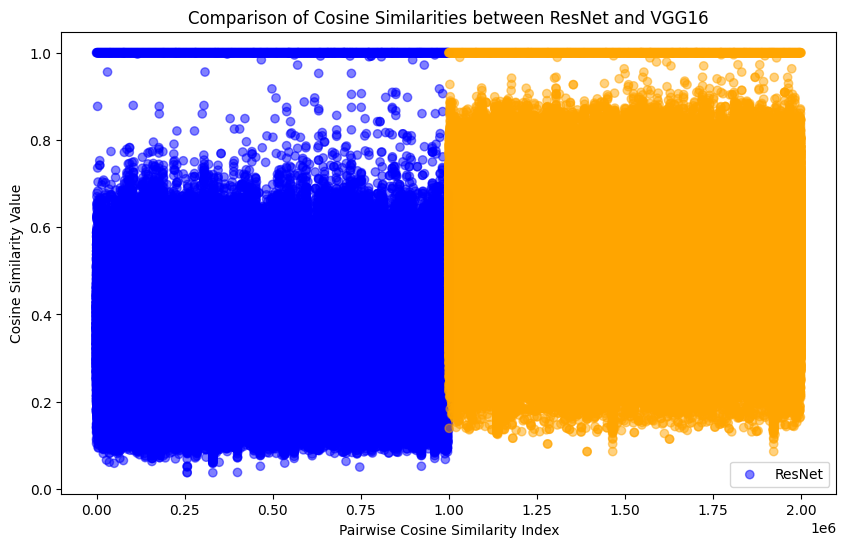

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


cos_sim_resnet = cos_similarities_df_resnet.values
cos_sim_vgg = cos_similarities_df.values

model_labels_resnet = np.full_like(cos_sim_resnet, 0)  
model_labels_vgg = np.full_like(cos_sim_vgg, 1)        

# Combine cosine similarities and model labels into one array for plotting
all_cos_similarities = np.concatenate([cos_sim_resnet.flatten(), cos_sim_vgg.flatten()])
all_model_labels = np.concatenate([model_labels_resnet.flatten(), model_labels_vgg.flatten()])

all_model_labels = all_model_labels.astype(int)

# Create a color map for ResNet (blue) and VGG16 (orange)
colors = np.array(['blue', 'orange'])

plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_cos_similarities)), all_cos_similarities, c=colors[all_model_labels], alpha=0.5)

# Add labels and title
plt.xlabel('Pairwise Cosine Similarity Index')
plt.ylabel('Cosine Similarity Value')
plt.title('Comparison of Cosine Similarities between ResNet and VGG16')


plt.legend(['ResNet', 'VGG16'])
# And since cosine value is higher, then it's potentially better to provide the user with accurace recommendations.
plt.show()


# Retrieve the most similar products along with their ASIN

-----------------------------------------------------------------------
original product:


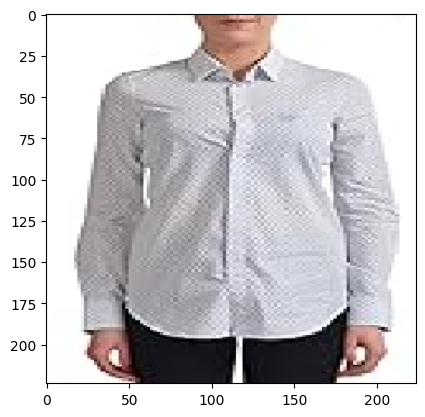

-----------------------------------------------------------------------
most similar products:
ASIN: B01758P216


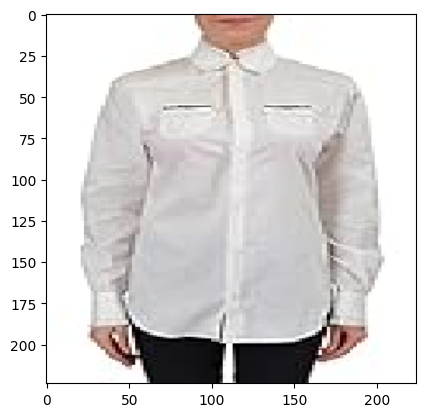

similarity score :  0.7081004
ASIN: B019DL6HJ4


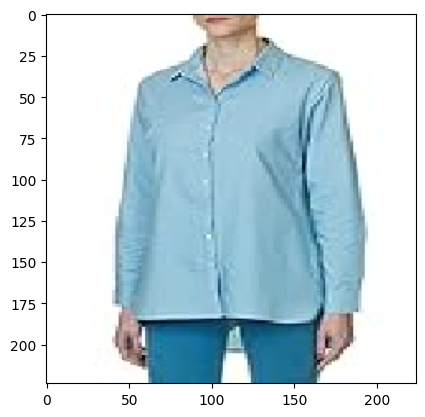

similarity score :  0.6362003
ASIN: B0755G4DJY


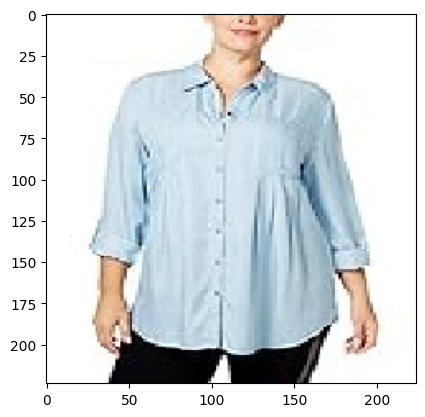

similarity score :  0.63213295
ASIN: B00WTEL180


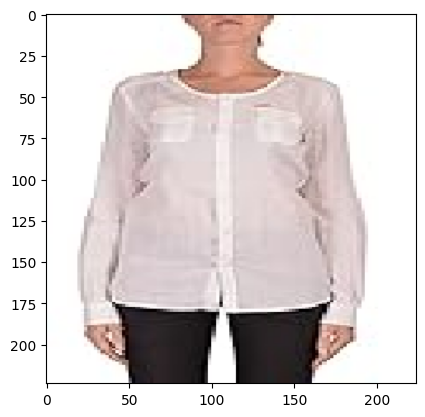

similarity score :  0.6285273
ASIN: B074FVPNRR


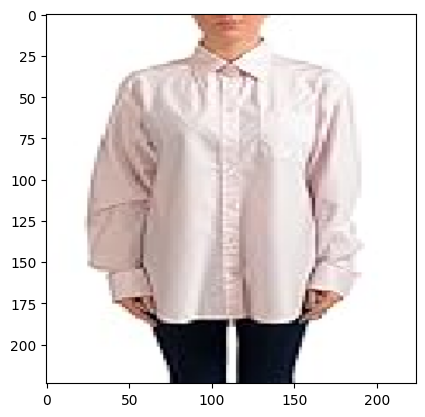

similarity score :  0.623228


In [ ]:
def retrieve_most_similar_products_resnet(given_img, data):
    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    print("-----------------------------------------------------------------------")
    print("most similar products:")
    closest_imgs_resnet = cos_similarities_df_resnet[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores_resnet = cos_similarities_df_resnet[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    for i in range(0, len(closest_imgs_resnet)):
        asin = os.path.splitext(os.path.basename(closest_imgs_resnet[i]))[0]
        print("ASIN:", asin)
        original = load_img(closest_imgs_resnet[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ", closest_imgs_scores_resnet[i])

# Example usage
retrieve_most_similar_products_resnet(files[20], data)


